# 50 оттенков градиентного спуска 

В этом задании вам предстоит реализовать линейный классификатор и натренировать его, используя различные модификации градинетного спуска. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

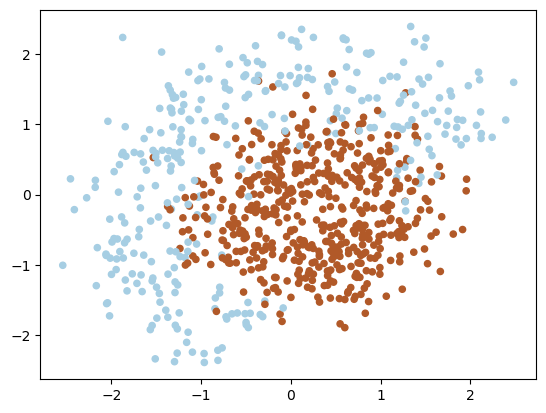

In [2]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

## Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [3]:
def expand(X):
    """
    Добавляет квадратичные фичи. 
    Для каждой строки матрицы находит строку 
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """

    # Извлекаем два исходных признака
    feature0 = X[:, 0]
    feature1 = X[:, 1]

    # Добавляем новые признаки: квадраты и произведение
    expanded_features = np.column_stack([
        feature0,               # feature0 (x1)
        feature1,               # feature1 (x2)
        feature0 ** 2,          # x1^2
        feature1 ** 2,          # x2^2
        feature0 * feature1,    # x1 * x2
        np.ones(X.shape[0])     # Константный член 1
    ])
    
    return expanded_features

## Логистическая регрессия 

Для классификации будем использовать логистическую регрессию. 

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [4]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)
    
    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """

    # Скалярное произведение X и w
    z = np.dot(X, w)
    
    # Применяем сигмоидную функцию
    probabilities = 1 / (1 + np.exp(-z))
    
    return probabilities

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии: 

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [5]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """

    # Вычисляем вероятности P(y=1 | x, w)
    p = probability(X, w)
    
    # Ограничим значения вероятностей, чтобы избежать log(0)
    p = np.clip(p, 1e-15, 1 - 1e-15)
    
    # Количество примеров
    l = len(y)
    
    # Вычисляем функцию потерь
    loss = - (1 / l) * np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    return loss

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой! 

$$ \nabla_w L = ...$$

In [6]:
def compute_grad(X, y, w):
    """
    Вычисляет градиент функции потерь логистической регрессии.
    
    :param X: расширенная матрица фичей [n_samples, 6] (expanded)
    :param y: вектор истинных меток [n_samples]
    :param w: вектор весов [6]
    :returns: градиент функции потерь по весам [6]
    """
    # Количество примеров
    l = len(y)
    
    # Вычисляем вероятности P(y=1 | x, w)
    p = probability(X, w)
    
    # Вычисляем разницу между предсказанными вероятностями и истинными метками
    diff = p - y
    
    # Вычисляем градиент
    grad = (1 / l) * np.dot(X.T, diff)
    
    return grad

Функция ниже предназначена для визуализации процесса обучения. 

In [7]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

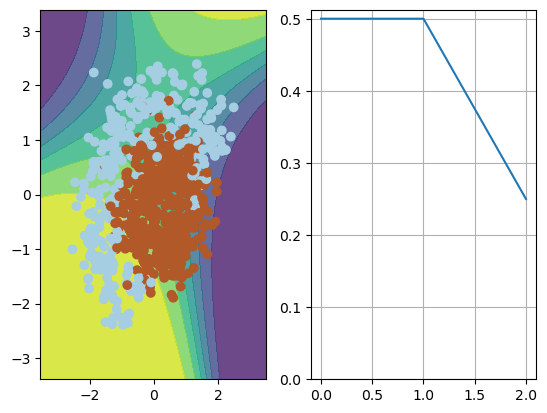

In [8]:
# убедитесь, что у вас она работает, запустив код ниже 
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация. 

## Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним! 

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



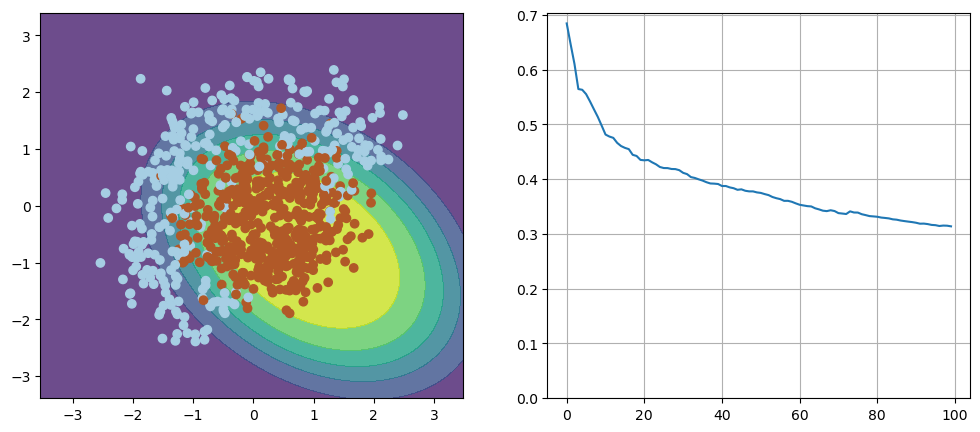

<Figure size 640x480 with 0 Axes>

In [11]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1], dtype=float)

eta= 0.1 

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    
    # Шаг 1: случайно выбираем индексы для батча
    batch_indices = np.random.choice(len(X), batch_size, replace=False)
    
    # Шаг 2: создаём батч признаков и меток
    X_batch = X[batch_indices]
    y_batch = y[batch_indices]
    
    # Расширяем матрицу признаков для батча
    X_batch_expanded = expand(X_batch)
    
    # Шаг 3: вычисляем градиент по батчу
    grad = compute_grad(X_batch_expanded, y_batch, w)
    
    # Шаг 4: обновляем веса с учётом градиента
    w -= eta * grad
    
    # Шаг 5: вычисляем и сохраняем функцию потерь на полной выборке для контроля
    loss[i] = compute_loss(expand(X), y, w)  # Используем расширенную матрицу

visualize(X, y, w, loss)
plt.clf()

## Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$. 
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


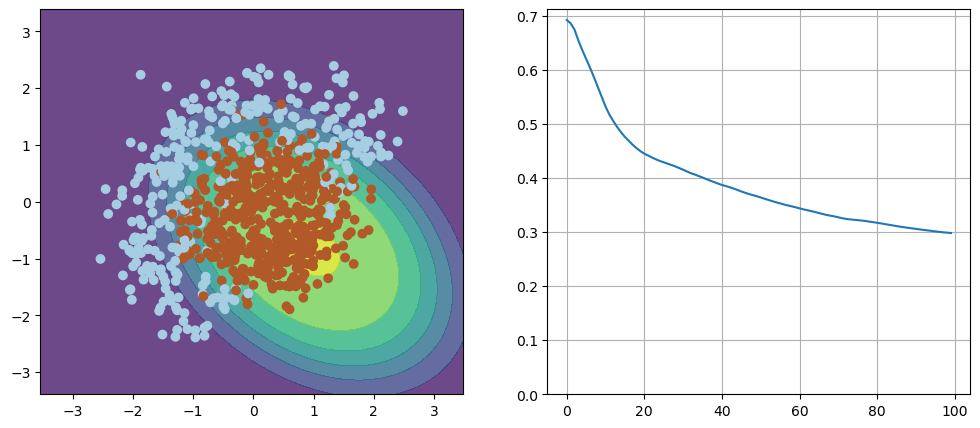

<Figure size 640x480 with 0 Axes>

In [12]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1], dtype=float)

eta = 0.05 
alpha = 0.9 
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    
    # Шаг 1: случайно выбираем индексы для батча
    batch_indices = np.random.choice(len(X), batch_size, replace=False)
    
    # Шаг 2: создаём батч признаков и меток
    X_batch = X[batch_indices]
    y_batch = y[batch_indices]
    
    # Расширяем матрицу признаков для батча
    X_batch_expanded = expand(X_batch)
    
    # Шаг 3: вычисляем градиент по батчу
    grad = compute_grad(X_batch_expanded, y_batch, w)
    
    # Шаг 4: обновляем вектор скорости
    nu = alpha * nu + (eta / batch_size) * grad  # Накопленный градиент
    
    # Шаг 5: обновляем веса с учётом скорости
    w -= nu
    
    # Шаг 6: вычисляем и сохраняем функцию потерь на полной выборке для контроля
    loss[i] = compute_loss(expand(X), y, w)  # Используем расширенную матрицу

visualize(X, y, w, loss)
plt.clf()

## RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра. 

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

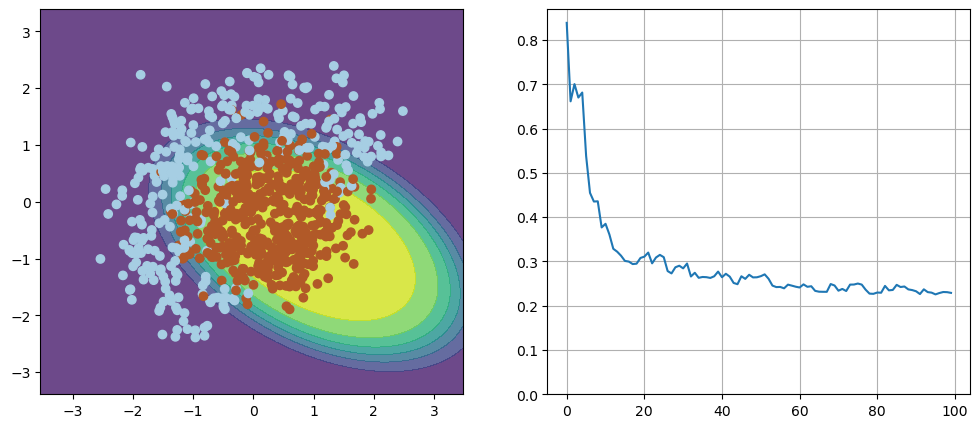

<Figure size 640x480 with 0 Axes>

In [13]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 
alpha = 0.9 
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):

    # Шаг 1: случайно выбираем индексы для батча
    batch_indices = np.random.choice(len(X), batch_size, replace=False)
    
    # Шаг 2: создаём батч признаков и меток
    X_batch = X[batch_indices]
    y_batch = y[batch_indices]
    
    # Шаг 3: расширяем матрицу признаков для батча
    X_batch_expanded = expand(X_batch)
    
    # Шаг 4: вычисляем градиент по батчу
    grad = compute_grad(X_batch_expanded, y_batch, w)
    
    # Шаг 5: обновляем накопленные квадраты градиентов
    g2 = alpha * g2 + (1 - alpha) * grad**2  # Nакопление квадратов градиента
    
    # Шаг 6: обновляем веса с учётом RMSprop
    w -= (eta / (np.sqrt(g2) + eps)) * grad  # Обновление весов
    
    # Шаг 7: вычисляем и сохраняем функцию потерь на полной выборке для контроля
    loss[i] = compute_loss(expand(X), y, w)  # Используем расширенную матрицу

visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam? 

## Отличия между вариациями градиентного спуска
### 1. Скорость сходимости:
Обычный SGD (Stochastic Gradient Descent) может сходиться медленно, особенно если градиенты имеют высокий разброс, что может привести к колебаниям вокруг минимума.
Momentum помогает ускорить сходимость, так как он сохраняет направление градиента и сглаживает траекторию, что может уменьшить колебания.
RMSprop адаптирует скорость обучения для каждого параметра, что может привести к более быстрой сходимости, особенно в случае сильно разреженных градиентов.
Adam (Adaptive Moment Estimation) сочетает идеи из Momentum и RMSprop, что позволяет ему еще быстрее адаптировать скорости обучения и сохранять направления градиентов.
### 2. Стабильность:
Momentum может привести к overshooting (перепрыгиванию) мимо минимума, особенно если скорость обучения велика.
RMSprop и Adam обычно более стабильны благодаря адаптивной корректировке скорости обучения.
### 3. Траектория:
Траектории могут выглядеть более гладкими или резкими в зависимости от выбранного метода. Например, Momentum может демонстрировать более плавные изменения в весах, в то время как SGD может показывать более резкие изменения.

Эти различия в поведении можно ожидать, так как каждая модификация градиентного спуска имеет свои особенности в том, как они обрабатывают информацию о градиентах. Например, Momentum учитывает прошлые градиенты, что помогает предотвратить нежелательные колебания, в то время как RMSprop адаптирует скорость обучения на основе предыдущих градиентов, что помогает в случае разреженных градиентов.

# Оптимизатор Adam

Оптимизатор Adam (Adaptive Moment Estimation) — это метод, который объединяет преимущества двух других методов: 

- **Momentum**, который сохраняет направление градиента.
- **RMSprop**, который адаптирует скорость обучения для каждого параметра.

## Основные формулы

1. **Обновление первого момента:**
   $$
   m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
   $$

2. **Обновление второго момента:**
   $$
   v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
   $$

3. **Коррекция смещения для моментов:**
   $$
   \hat{m}_t = \frac{m_t}{1 - \beta_1^t}
   $$
   $$
   \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
   $$

4. **Обновление весов:**
   $$
   w_t = w_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
   $$

## Параметры

- $\eta$: скорость обучения.
- $\beta_1$: параметр затухания для первого момента (обычно $0.9$).
- $\beta_2$: параметр затухания для второго момента (обычно $0.999$).
- $\epsilon$: малое значение для предотвращения деления на ноль (обычно $1e-8$).

## Шаги алгоритма

1. Инициализируйте:
   - $m = 0$
   - $v = 0$
   - $t = 0$

2. На каждой итерации:
   - Увеличьте $t$ на 1.
   - Вычислите градиент $g_t$.
   - Обновите моменты $m_t$ и $v_t$ по формуле (1) и (2).
   - Корректируйте моменты 

    w -= eta * m_hat / (np.sqrt(v_hat) + epsilon)  # обновление весов


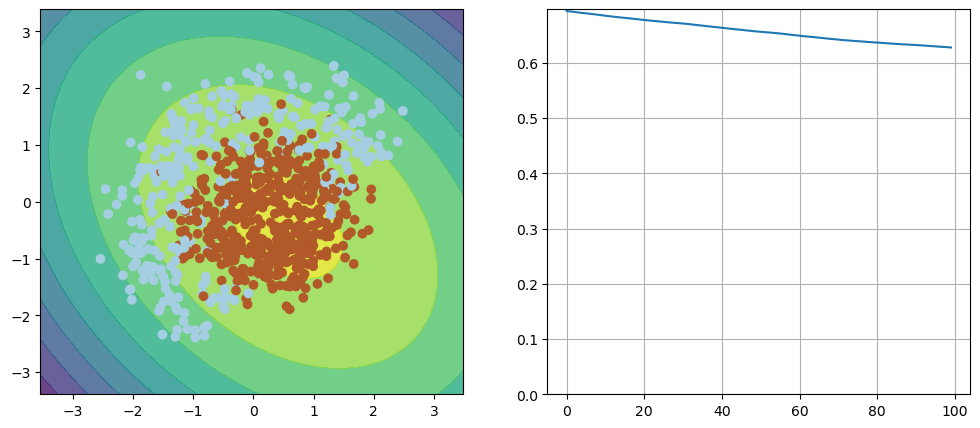

<Figure size 640x480 with 0 Axes>

In [18]:
# Реализация оптимизатора Adam
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1.])  # Начальные веса

eta = 0.001  # Скорость обучения
beta1 = 0.9  # Параметр затухания для первого момента
beta2 = 0.999  # Параметр затухания для второго момента
m = np.zeros_like(w)  # Инициализация первого момента
v = np.zeros_like(w)  # Инициализация второго момента
epsilon = 1e-8  # Малое значение для численной стабильности

n_iter = 100  # Количество итераций
batch_size = 4  # Размер батча
loss = np.zeros(n_iter)  # Массив для хранения значений потерь

plt.figure(figsize=(12, 5))  # Установка размера фигуры

for t in range(1, n_iter + 1):
    
    # Шаг 1: случайный выбор индексов для батча
    batch_indices = np.random.choice(len(X), batch_size, replace=False)
    
    # Шаг 2: создание батча признаков и меток
    X_batch = X[batch_indices]
    y_batch = y[batch_indices]
    
    # Шаг 3: расширение матрицы признаков для батча
    X_batch_expanded = expand(X_batch)
    
    # Шаг 4: вычисление градиента для батча
    grad = compute_grad(X_batch_expanded, y_batch, w)
    
    # Шаг 5: обновление первых и вторых моментов
    m = beta1 * m + (1 - beta1) * grad  # Первый момент
    v = beta2 * v + (1 - beta2) * (grad ** 2)  # Второй момент
    
    # Шаг 6: коррекция смещения
    m_hat = m / (1 - beta1 ** t)  # Коррекция первого момента
    v_hat = v / (1 - beta2 ** t)  # Коррекция второго момента
    
    # Шаг 7: обновление весов
    w -= eta * m_hat / (np.sqrt(v_hat) + epsilon)

    # Сохранение потерь для мониторинга
    loss[t-1] = compute_loss(expand(X), y, w)  # Используем расширенную матрицу

# Визуализация
visualize(X, y, w, loss)
plt.clf()
